In [1]:
import torch
import torchvision

import cv2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import multiprocessing

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
train_images = {}
train_images_dir = 'data/train/'

for idx,row in df_train.iterrows():
    filepath = f'{train_images_dir}/{row['Image_ID']}.jpg'
    train_images[row['Image_ID']] = torchvision.io.decode_image(filepath)
    

test_images = {}
test_images_dir = 'data/test/'

for idx,row in df_test.iterrows():
    filepath = f'{test_images_dir}/{row['Image_ID']}.jpg'
    test_images[row['Image_ID']] = torchvision.io.decode_image(filepath)

In [4]:
df_train.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [5]:
df_test.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [6]:
len(df_train['Image_ID'].unique())

3001

In [7]:
def get_all_bboxes_imid(df, image_id):
    image_instances = df[df['Image_ID'] == image_id]
    bboxes = []
    for _,row in image_instances.iterrows():
        bboxes.append({'class': row['class'], 
                       'xmin': row['xmin'], 'ymin': row['ymin'], 'width': row['width'], 
                       'height': row['height']})

    return bboxes

def deduplicate_images_in_df(df):
    rows = []
    for image_id in df['Image_ID'].unique():
        rows.append({'Image_ID': image_id, 'labels': get_all_bboxes_imid(df, image_id)})
    
    return pd.DataFrame(rows)
    
df_train_dup = df_train.copy()
df_train = deduplicate_images_in_df(df_train)
df_train.head()

,Image_ID,labels
0,ID_007FAIEI,"[{'class': 'fruit_woodiness', 'xmin': 87.0, 'y..."
1,ID_00G8K1V3,"[{'class': 'fruit_brownspot', 'xmin': 97.5, 'y..."
2,ID_00WROUT9,"[{'class': 'fruit_brownspot', 'xmin': 156.5, '..."
3,ID_00ZJEEK3,"[{'class': 'fruit_healthy', 'xmin': 125.0, 'ym..."
4,ID_018UIENR,"[{'class': 'fruit_brownspot', 'xmin': 79.5, 'y..."


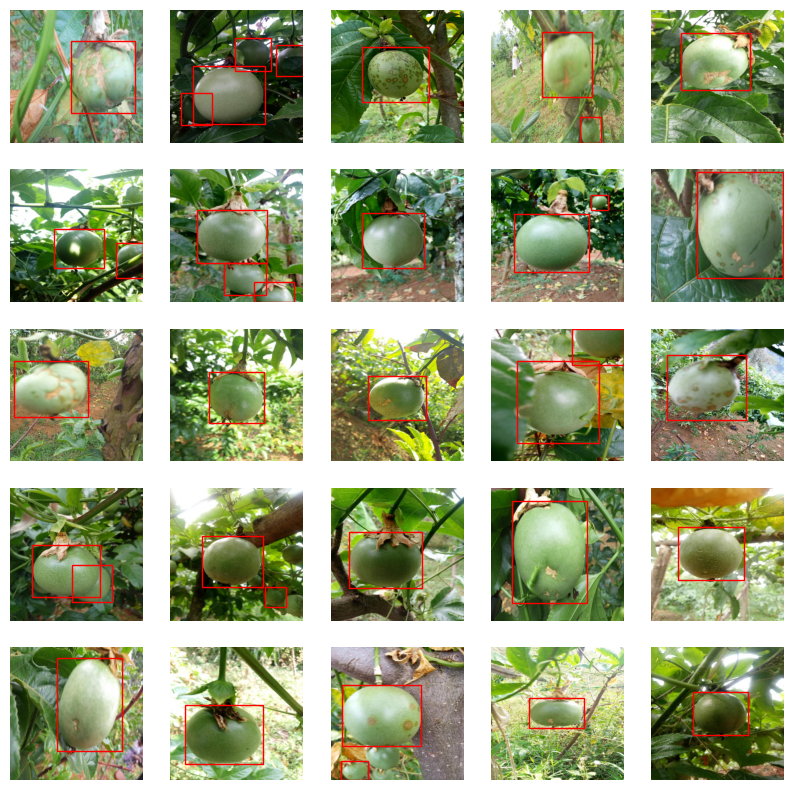

In [8]:
def plot_images(df, rows=5, cols=5):
    fig, ax = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            ax[row,col].axis('off')
            
            idx = np.random.randint(len(df['Image_ID']), size=1)[0]
            iid = df['Image_ID'].iat[idx]
            transposed_image = torch.transpose(torch.transpose(train_images[iid], 0, 2), 0, 1)
            ax[row,col].imshow(transposed_image)

            bboxes = df['labels'].iat[idx]

            for bbox in bboxes:
                rect = Rectangle((bbox['xmin'],bbox['ymin']), bbox['width'], bbox['height'], linewidth=1, edgecolor='r', facecolor='none')
                ax[row,col].add_patch(rect)
plot_images(df_train)

In [9]:
df_train['count'] = df_train.apply(lambda x: len(x['labels']), axis=1)
df_train[df_train['count'] > 1].head()

,Image_ID,labels,count
6,ID_02PX7GI8,"[{'class': 'fruit_brownspot', 'xmin': 1.5, 'ym...",2
11,ID_05A7I1ZP,"[{'class': 'fruit_woodiness', 'xmin': 321.0, '...",2
14,ID_05V8XX4L,"[{'class': 'fruit_woodiness', 'xmin': 286.5, '...",2
18,ID_06N0H7F1,"[{'class': 'fruit_healthy', 'xmin': 91.0, 'ymi...",2
19,ID_07HGJOFB,"[{'class': 'fruit_healthy', 'xmin': 283.0, 'ym...",3


<Axes: xlabel='count', ylabel='Count'>

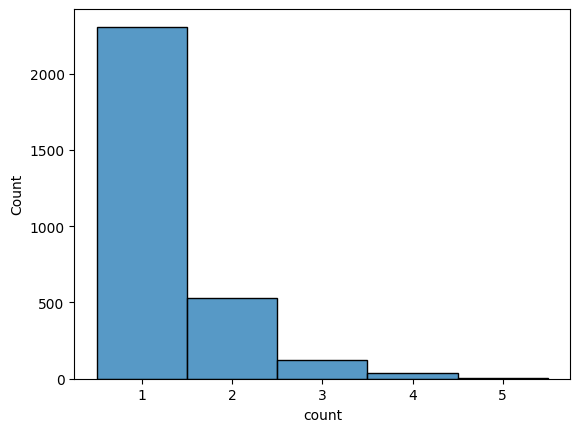

In [10]:
sns.histplot(df_train['count'], discrete=True)

<Axes: ylabel='Count'>

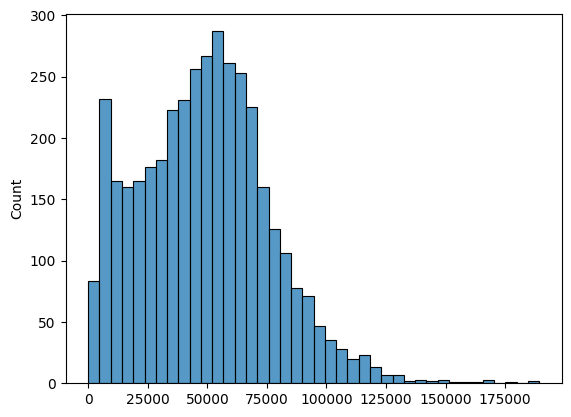

In [11]:
sns.histplot(df_train_dup['width']*df_train_dup['height'])

In [43]:
def get_mean_hue(row):
    hsv = cv2.cvtColor(torch.transpose(torch.transpose(train_images[row['Image_ID']], 0, 2), 0, 1).numpy(), cv2.COLOR_RGB2HSV)
    hues = hsv[((hsv[:,:,1] > 40) & (hsv[:,:,2] > 20) & (hsv[:,:,2] < 240))]
    hues = hsv[:,:,0]
    x = np.cos(hues*np.pi/180);
    y = np.sin(hues*np.pi/180);
    hue = np.arctan2(np.mean(y),np.mean(x))*(180/np.pi)
    return hue
    #hue = hue if hue > 0 else hue + 360
    
df_train['augmentation'] = False
df_train['brightness'] = df_train.apply(lambda row: (np.array(cv2.cvtColor(torch.transpose(torch.transpose(train_images[row['Image_ID']], 0, 2), 0, 1).numpy(), cv2.COLOR_BGR2GRAY)).mean()),  axis=1)  
df_train['hue'] = df_train.apply(lambda row: get_mean_hue(row),  axis=1)  
df_train.head()

,Image_ID,labels,count,brightness,hue,augmentation
0,ID_007FAIEI,"[{'class': 'fruit_woodiness', 'xmin': 87.0, 'y...",1,153.687607,39.031781,False
1,ID_00G8K1V3,"[{'class': 'fruit_brownspot', 'xmin': 97.5, 'y...",1,132.819569,32.629083,False
2,ID_00WROUT9,"[{'class': 'fruit_brownspot', 'xmin': 156.5, '...",1,98.311352,39.200606,False
3,ID_00ZJEEK3,"[{'class': 'fruit_healthy', 'xmin': 125.0, 'ym...",1,97.785294,51.600160,False
4,ID_018UIENR,"[{'class': 'fruit_brownspot', 'xmin': 79.5, 'y...",1,98.852459,33.776660,False


<Axes: xlabel='hue', ylabel='Count'>

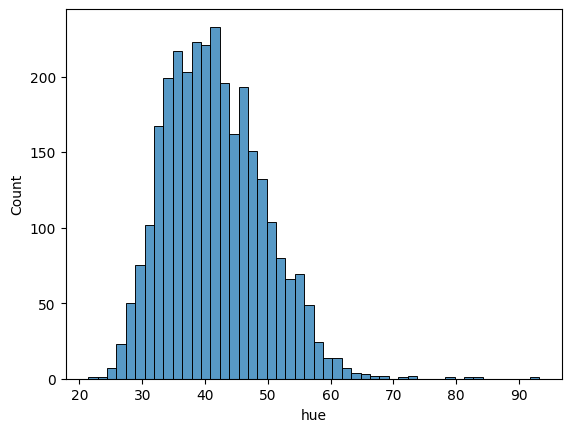

In [13]:
sns.histplot(df_train['hue'])

In [14]:
df_train[df_train['hue'] < 26]

,Image_ID,labels,count,brightness,hue
923,ID_AX9HDLIZ,"[{'class': 'fruit_woodiness', 'xmin': 61.5, 'y...",1,138.735954,24.694232
1150,ID_DPV8ZOVG,"[{'class': 'fruit_brownspot', 'xmin': 37.5, 'y...",1,133.630966,25.276283
1173,ID_DZ2T99QC,"[{'class': 'fruit_woodiness', 'xmin': 15.5, 'y...",1,140.438072,25.644396
1408,ID_GQ7QCO7N,"[{'class': 'fruit_woodiness', 'xmin': 26.0, 'y...",1,125.930603,21.401046
1593,ID_J8CNS01T,"[{'class': 'fruit_woodiness', 'xmin': 189.5, '...",1,126.331520,24.871606
1806,ID_LMU1D9EO,"[{'class': 'fruit_woodiness', 'xmin': 130.0, '...",1,149.117531,24.966583
2096,ID_PAEXSU1A,"[{'class': 'fruit_brownspot', 'xmin': 55.5, 'y...",1,92.953438,23.523385
2584,ID_V4CBWUKE,"[{'class': 'fruit_brownspot', 'xmin': 52.0, 'y...",1,111.852337,25.404479
2931,ID_ZAUV85BC,"[{'class': 'fruit_brownspot', 'xmin': 1.5, 'ym...",1,123.377762,25.467879


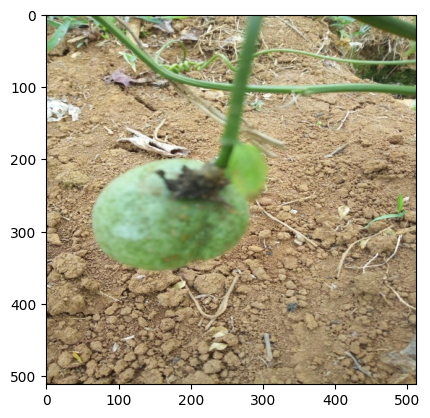

In [15]:
transposed_image = torch.transpose(torch.transpose(train_images['ID_AX9HDLIZ'], 0, 2), 0, 1)
plt.imshow(transposed_image)

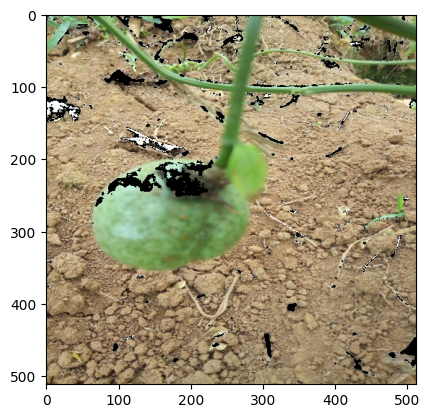

In [16]:
hsv = cv2.cvtColor(torch.transpose(torch.transpose(train_images['ID_AX9HDLIZ'], 0, 2), 0, 1).numpy(), cv2.COLOR_RGB2HSV)
hsv[~(hsv[:,:,1] > 40) & (hsv[:,:,2] > 20) & (hsv[:,:,2] < 240)] = 0
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.imshow(rgb)

In [17]:
hsv[hsv[:,:,0] < 30].shape

(213210, 3)

In [18]:
hsv[0,0,:]

array([ 75,  52, 192], dtype=uint8)

In [19]:
hsv[:,:,0].max()

178

In [20]:
hues = hsv[:,:,0][(hsv[:,:,1] > 80) & (hsv[:,:,2] > 80)]
x = np.cos(hues*np.pi/180);
y = np.sin(hues*np.pi/180);
hue = np.arctan2(np.mean(y),np.mean(x))*(180/np.pi)

In [21]:
(hsv[:,:,1] > 80) & (hsv[:,:,2] > 80) & (hsv[:,:,2] < 220)

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

<Axes: xlabel='class', ylabel='Count'>

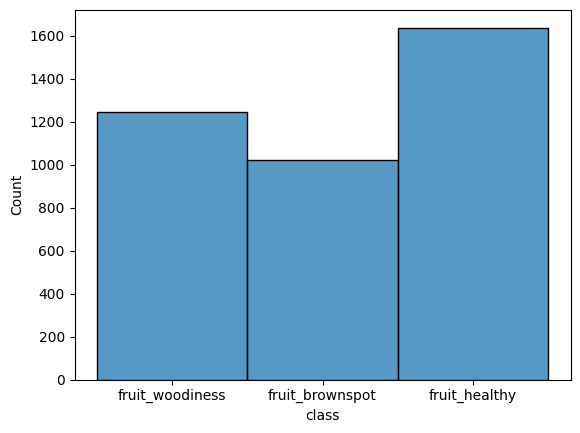

In [22]:
sns.histplot(df_train_dup['class'])

In [49]:
import albumentations
import PIL
import uuid

transformations = albumentations.Compose([
    albumentations.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.2),
    albumentations.ChromaticAberration(primary_distortion_limit=0.05, secondary_distortion_limit=0.1,
                                       mode='green_purple', interpolation=cv2.INTER_LINEAR, p=1.0),
    albumentations.ImageCompression(quality_range=(50, 90), compression_type='jpeg', p=1.0),
    albumentations.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.2), p=0.5)
], p=1.0, bbox_params=albumentations.BboxParams(format='coco', min_visibility=0.2, label_fields=['category_id']))

In [50]:
# One hot encode the classes to indicies
category_id_map = {}
for idx, label_class in enumerate(list(df_train_dup['class'].unique())):
    category_id_map[label_class] = idx

print(category_id_map)

{'fruit_woodiness': 0, 'fruit_brownspot': 1, 'fruit_healthy': 2}


In [51]:
def label_list_to_coco_bbox_list(category_map, label_list):
    category_ids = []
    bbox_list = []
    for label in label_list:
        category_ids.append(category_map[label['class']])
        bbox_list.append([label['xmin'], label['ymin'], label['width'], label['height']])
    
    return bbox_list, category_ids

def coco_bbox_list_to_label_list(category_map, bboxes, categories):
    label_list = []
    for idx, bbox in enumerate(bboxes):
        category_id = categories[idx]
        classification = None
        for name, id in category_map.items():
            if id == category_id:
                classification = name
        if classification is None:
            raise ValueError
            
        label = {'class': classification, 'xmin': bbox[0], 'ymin': bbox[1], 'width': bbox[2], 'height': bbox[3]}
        label_list.append(label)
    return label_list

In [53]:
def apply_transforms(transformations, df, images, category_id_map, n_transforms=4):
    new_image_metadata = {'Image_ID': [], 'labels': [], 'count': [], 'brightness': [], 'hue': [], 'augmentation': []}

    for i in range(n_transforms):
        for idx, row in df.iterrows():
            if row['augmentation']:
                continue
            
            bboxes, categories = label_list_to_coco_bbox_list(category_id_map, row['labels'])
            image = torch.transpose(torch.transpose(images[row['Image_ID']], 0, 2), 0, 1).numpy()
            augmented_boxes = transformations(image=image, bboxes=bboxes, category_id=categories)
            bboxes_aug = augmented_boxes['bboxes']
            categories = augmented_boxes['category_id']
            image_aug = augmented_boxes['image']
            image_id = 'augmentations/' + row['Image_ID'] + '-' + str(uuid.uuid4())
            PIL.Image.fromarray(image_aug).save(train_images_dir + image_id + '.jpg', "JPEG")
            
            labels = coco_bbox_list_to_label_list(category_id_map, bboxes_aug, categories)
    
            brightness = cv2.cvtColor(image_aug, cv2.COLOR_RGB2GRAY).mean()
    
            hsv = cv2.cvtColor(image_aug, cv2.COLOR_RGB2HSV)
            hues = hsv[((hsv[:,:,1] > 40) & (hsv[:,:,2] > 20) & (hsv[:,:,2] < 240))]
            hues = hsv[:,:,0]
            x = np.cos(hues*np.pi/180);
            y = np.sin(hues*np.pi/180);
            hue = np.arctan2(np.mean(y),np.mean(x))*(180/np.pi)
    
            new_image_metadata['Image_ID'].append(image_id)
            new_image_metadata['labels'].append(labels)
            new_image_metadata['count'].append(len(labels))
            new_image_metadata['augmentation'].append(True)
            new_image_metadata['brightness'].append(brightness)
            new_image_metadata['hue'].append(hue)    

    df = pd.concat([df, pd.DataFrame(new_image_metadata)])

    return df

df_train_aug = apply_transforms(transformations, df_train, train_images,category_id_map)